# 5. Analysis

Time for some machine learning!

In [3]:
# set up some dependencies
import json, time, random, csv
import numpy as np
import geopandas as gp
import pandas as pd
import matplotlib.pyplot as plt
import descartes # for plotting with geopanadas

In [4]:
# set up path to app credentials - see exploration/README.md
%env GOOGLE_APPLICATION_CREDENTIALS=../google_app_credentials.json

# set up bigquery client
from google.cloud import bigquery
bq = bigquery.Client()

env: GOOGLE_APPLICATION_CREDENTIALS=../google_app_credentials.json


In [5]:
# grab valid years and check BigQuery connection
resp = bq.query('''
    SELECT DISTINCT do_date AS year
    FROM `eosc410-project.data.acs_cbsa_20*`
    ORDER BY do_date ASC
''')
years = [row["year"] for row in resp]

In [6]:
'''
Gets the GeoID from the combined ID
'''
def combined_id_to_geoid(combined_id: str) -> str:
    parts = combined_id.split('.')
    if len(parts) < 1:
        return ''
    return parts[0]
def combined_id_to_epa_param(combined_id: str) -> str:
    parts = combined_id.split('.')
    if len(parts) < 3:
        return ''
    return parts[len(parts)-1]

In [7]:
# load up aggregated data - refer to _data/acs/README.md and _data/epa/README.md
acs_ts_flat = pd.read_csv('../docs/_data/acs/timeseries_flat.csv')
acs_ts_vert = pd.read_csv('../docs/_data/acs/timeseries_vert.csv')
acs_ts_vert_alt = pd.read_csv('../docs/_data/acs/timeseries_vert_alt.csv',index_col=0)
epa_ts_flat = pd.read_csv('../docs/_data/epa/timeseries_flat.csv')
epa_ts_vert = pd.read_csv('../docs/_data/epa/timeseries_vert.csv')

# take a peak at what's up
print('==== ACS Aggregates\n')
print(acs_ts_vert_alt.dtypes, '\n')
# print('==== EPA Aggregates\n')
# print(epa_ts_flat.dtypes, '\n')
# print(epa_ts_vert.dtypes, '\n')

==== ACS Aggregates

geoid                                        int64
2007.commute_10_29_mins                    float64
2007.commute_30_59_mins                    float64
2007.commute_over_60_mins                  float64
2007.commute_under_10_mins                 float64
                                            ...   
2018.rent_over_50_percent                  float64
2018.rent_under_25_percent                 float64
2018.some_college_and_associates_degree    float64
2018.total_pop                             float64
2018.walked_to_work                        float64
Length: 337, dtype: object 



In [8]:
resp = bq.query('''
SELECT DISTINCT(geo_id) AS geoid
FROM `eosc410-project.data.acs_cbsa_20*` # multi-table query
''')
geoids = [row["geoid"] for row in resp]
len(geoids)

557

In [129]:
# find epa value for corresponding geoids
epa_aggs = pd.DataFrame(data={'geoid': geoids})
for index, row in epa_aggs.iterrows():
    geoid = row['geoid']
    rows_with_geoid = epa_ts_vert[epa_ts_vert['combined_id'].str.startswith("%s." % geoid)]
    for param in ['88502', '68105']:
        # columns: [combined_id, year.stdev, year.mean, ...]
        # rows: combined_id with this geoid, param
        rows_with_param = rows_with_geoid[rows_with_geoid['combined_id'].str.endswith(".%s" % param)]
        rows_with_param['geoid'] = [geoid for i in range(len(rows_with_param))]

        # want:
        # columns: [geoid, year.mean, year.stdev]
        def rename_column(col):
            if col.startswith('2'):
                return '%s.%s' % (col, param)
            return col
        row_data = rows_with_param.dropna().groupby(['geoid']).mean().rename(columns=lambda col: rename_column(col))
        if len(row_data) > 0:
            for (col, data) in row_data.iteritems():
                epa_aggs.loc[index, col] = data.iloc[0]

print('\n===\nresults')
epa_aggs.head()

    # rows_with_param_combined= rows_with_param.groupby('combined_id').agg(np.mean) #group geoid and get mean of each column
    # print('\n%d measurements of parameter %s for geoid %s' % (len(rows_with_param), param, geoid))
    # print(rows_with_param[['2007.mean', '2007.stdev']].head())


===
results


,geoid,Unnamed: 0,2007.mean.88502,2007.stdev.88502,2008.mean.88502,2008.stdev.88502,2009.mean.88502,2009.stdev.88502,2010.mean.88502,2010.stdev.88502,...,2014.mean.68105,2014.stdev.68105,2015.mean.68105,2015.stdev.68105,2016.mean.68105,2016.stdev.68105,2017.mean.68105,2017.stdev.68105,2018.mean.68105,2018.stdev.68105
0,46180,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,42940,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,34100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,32940,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [171]:
'''
Generate time series for given geoid
'''
def get_timeseries_for_geoid(geoid):
    epa_row = epa_aggs[epa_aggs.geoid==geoid]
    epa = pd.DataFrame(data={'year': years})
    for (col, vals) in epa_row.iteritems():
        if col.startswith('2'):
            year = col.split('.')[0]
            measurement = '%s.%s' % (col.split('.')[1], col.split('.')[2]) # 3-part combined id
            feature = '%s.epa.%s' % (geoid, measurement)
            row_index = epa.index[epa['year'] == year].tolist()[0] # should have single match
            epa.loc[row_index, feature] = vals.iloc[0] # should be single row

    acs = acs_ts_flat[['year'] + [col for col in acs_ts_flat if col.startswith(geoid)]]
    acs['year'] = acs['year'].astype(str)
    print(epa.head())

    geoid_df = pd.merge(acs, epa, on=['year'])
    geoid_df = geoid_df.loc[:, ~geoid_df.columns.str.contains('^Unnamed')]
    return geoid_df


In [173]:
df_41860 = get_timeseries_for_geoid('41860')
df_41860
df_41860.columns.values.tolist()

year  41860.epa.mean.88502  41860.epa.stdev.88502  41860.epa.mean.68105  \
0  2007              5.341525               3.711114                   NaN   
1  2008              6.110345               3.890733                   NaN   
2  2009              5.256250               3.379103                   NaN   
3  2010              5.086087               3.431610                   NaN   
4  2011              5.492000               3.956268                   NaN   

   41860.epa.stdev.68105  
0                    NaN  
1                    NaN  
2                    NaN  
3                    NaN  
4                    NaN  


['year',
 '41860.acs.commute_10_29_mins',
 '41860.acs.commute_30_59_mins',
 '41860.acs.commute_over_60_mins',
 '41860.acs.commute_under_10_mins',
 '41860.acs.commuters_by_car_truck_van',
 '41860.acs.commuters_by_public_transportation',
 '41860.acs.dwellings_20_to_49_units',
 '41860.acs.dwellings_50_or_more_units',
 '41860.acs.dwellings_5_to_19_units',
 '41860.acs.dwellings_under_4_units',
 '41860.acs.family_households',
 '41860.acs.gini_index',
 '41860.acs.graduate_professional_degree',
 '41860.acs.high_school_including_ged',
 '41860.acs.housing_units',
 '41860.acs.income_per_capita',
 '41860.acs.median_age',
 '41860.acs.median_rent',
 '41860.acs.median_structure_age',
 '41860.acs.nonfamily_households',
 '41860.acs.occupied_housing_units',
 '41860.acs.poverty',
 '41860.acs.rent_25_to_50_percent',
 '41860.acs.rent_over_50_percent',
 '41860.acs.rent_under_25_percent',
 '41860.acs.some_college_and_associates_degree',
 '41860.acs.total_pop',
 '41860.acs.walked_to_work',
 '41860.epa.mean.88

Text(0.5, 1.0, 'Distribution of features for geoid:41860 from 2007-2018')

<Figure size 5760x5760 with 0 Axes>

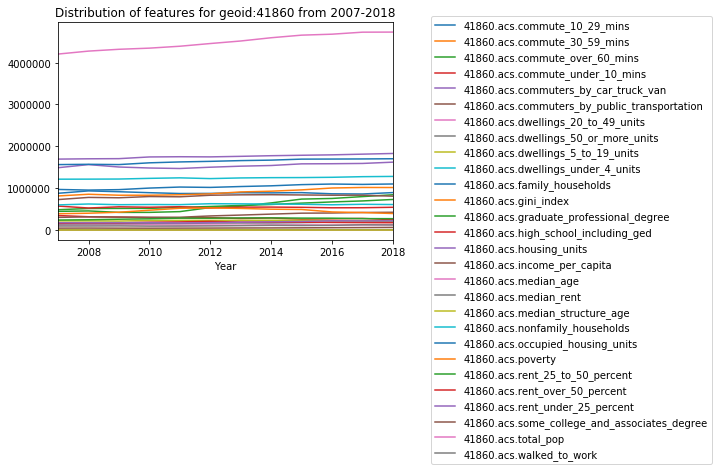

In [156]:
plt.figure(figsize=(80,80))
df_41860.set_index('year').plot()
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Distribution of features for geoid:41860 from 2007-2018')

In [174]:
# first, perform PCA to find spatial modes and understand relation between features 

from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler

# standardize data
features = ['41860.acs.commute_10_29_mins',
 '41860.acs.commute_30_59_mins',
 '41860.acs.commute_over_60_mins',
 '41860.acs.commute_under_10_mins',
 '41860.acs.commuters_by_car_truck_van',
 '41860.acs.commuters_by_public_transportation',
 '41860.acs.dwellings_20_to_49_units',
 '41860.acs.dwellings_50_or_more_units',
 '41860.acs.dwellings_5_to_19_units',
 '41860.acs.dwellings_under_4_units',
 '41860.acs.family_households',
 '41860.acs.gini_index',
 '41860.acs.graduate_professional_degree',
 '41860.acs.high_school_including_ged',
 '41860.acs.housing_units',
 '41860.acs.income_per_capita',
 '41860.acs.median_age',
 '41860.acs.median_rent',
 '41860.acs.median_structure_age',
 '41860.acs.nonfamily_households',
 '41860.acs.occupied_housing_units',
 '41860.acs.poverty',
 '41860.acs.rent_25_to_50_percent',
 '41860.acs.rent_over_50_percent',
 '41860.acs.rent_under_25_percent',
 '41860.acs.some_college_and_associates_degree',
 '41860.acs.total_pop',
 '41860.acs.walked_to_work']
# Separating out the features
x = df_41860.loc[:, features].values
# Separating out the target
y = df_41860.loc[:,['41860.epa.mean.88502','41860.epa.mean.68105']].values
# Standardizing the features
x = StandardScaler().fit_transform(x)

In [ ]:
# projection to 2D
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

